In [16]:
import csv
import math
import pandas as pd
import json
from socket import timeout

import numpy as np
import heartpy as hp
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import urllib.request
from scipy.signal import resample
from datetime import timezone, timedelta, datetime

In [17]:
activities_df = pd.read_csv('datas/CH-053a.csv')

activities_timestamps = {
    'start': pd.to_datetime(activities_df.iloc[0][2], unit='ms', utc=True).tz_convert(timezone(timedelta(hours=2))),
    'end': pd.to_datetime(activities_df.iloc[-1][2], unit='ms', utc=True).tz_convert(timezone(timedelta(hours=2))),
}

/var/folders/8f/j64d6tp11l35pf3_b05vxb0c0000gn/T/ipykernel_1772/621133427.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'start': pd.to_datetime(activities_df.iloc[0][2], unit='ms', utc=True).tz_convert(timezone(timedelta(hours=2))),
/var/folders/8f/j64d6tp11l35pf3_b05vxb0c0000gn/T/ipykernel_1772/621133427.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'end': pd.to_datetime(activities_df.iloc[-1][2], unit='ms', utc=True).tz_convert(timezone(timedelta(hours=2))),


In [18]:
df = pd.read_csv('datas/CH-053.csv')
df.keys()

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Europe/Paris')

# Filter the dataframe
filtered_df = df.loc[(df['timestamp'] > activities_timestamps['start']) & (df['timestamp'] < activities_timestamps['end'])]


In [19]:
# Assuming df is your original dataframe
# df['ppg'] = df[['eje_x', 'eje_y']].mean(axis=1)
df['ppg'] = df[['eje_x']]

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Format timestamp
df['timestamp'] = df['timestamp'].dt.strftime('%H:%M:%S.%f')

# Create new dataframe with mean_eje_xy and timestamp
new_df = df[['ppg', 'timestamp']]

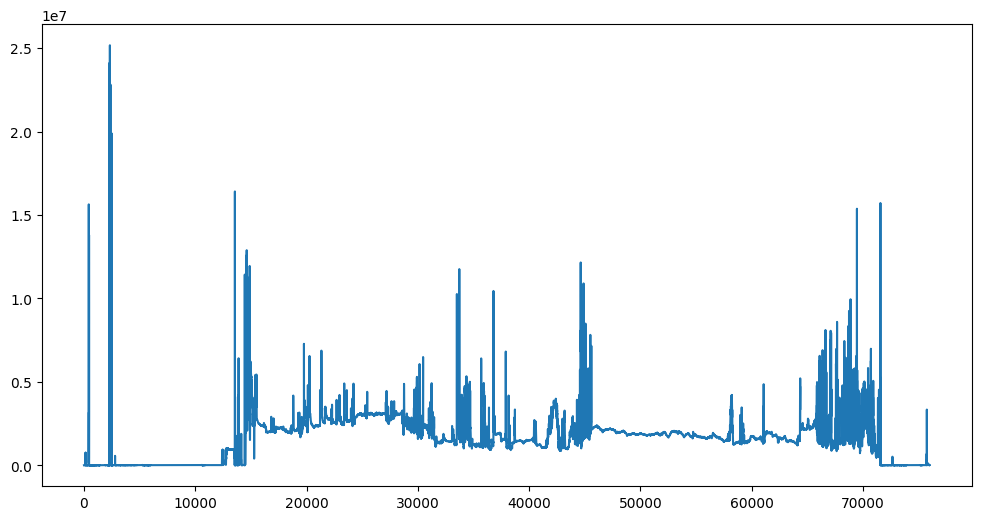

In [20]:
plt.figure(figsize=(12,6))

plt.plot(new_df['ppg'].values)
plt.show()

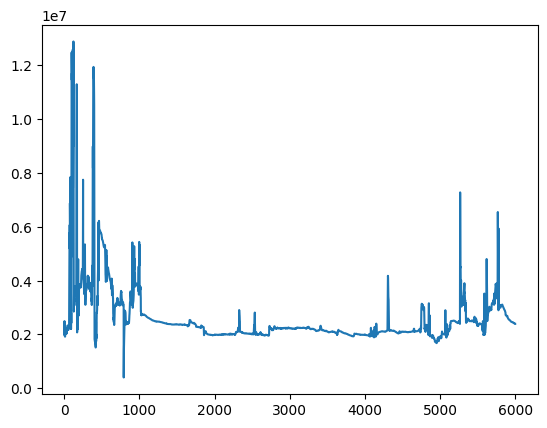

In [21]:
signal = df['ppg'].values[14500:20500]
timer = df['timestamp'].values[14500:20500]
plt.plot(signal)
plt.show()

In [22]:
sample_rate = hp.get_samplerate_datetime(timer, timeformat = '%H:%M:%S.%f')

print('sampling rate is: %.3f Hz' %sample_rate)

sampling rate is: 20.870 Hz


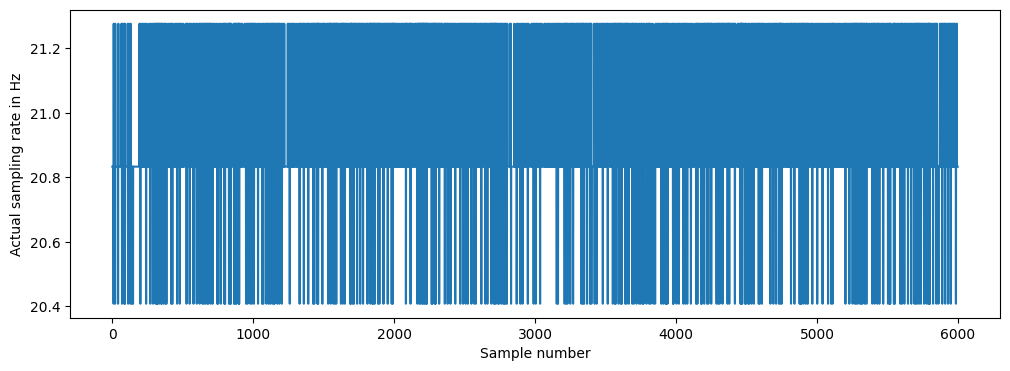

mean sampling rate: 20.868
median sampling rate: 20.833
standard deviation: 0.180


In [23]:
from datetime import datetime

#let's create a list 'newtimer' to house our datetime objects
newtimer = [datetime.strptime(x, '%H:%M:%S.%f') for x in timer]

#let's compute the real distances from entry to entry
elapsed = []
for i in range(len(newtimer) - 1):
    elapsed.append(1 / ((newtimer[i+1] - newtimer[i]).microseconds / 1000000))

#and plot the results
plt.figure(figsize=(12,4))
plt.plot(elapsed)
plt.xlabel('Sample number')
plt.ylabel('Actual sampling rate in Hz')
plt.show()

print('mean sampling rate: %.3f' %np.mean(elapsed))
print('median sampling rate: %.3f'%np.median(elapsed))
print('standard deviation: %.3f'%np.std(elapsed))

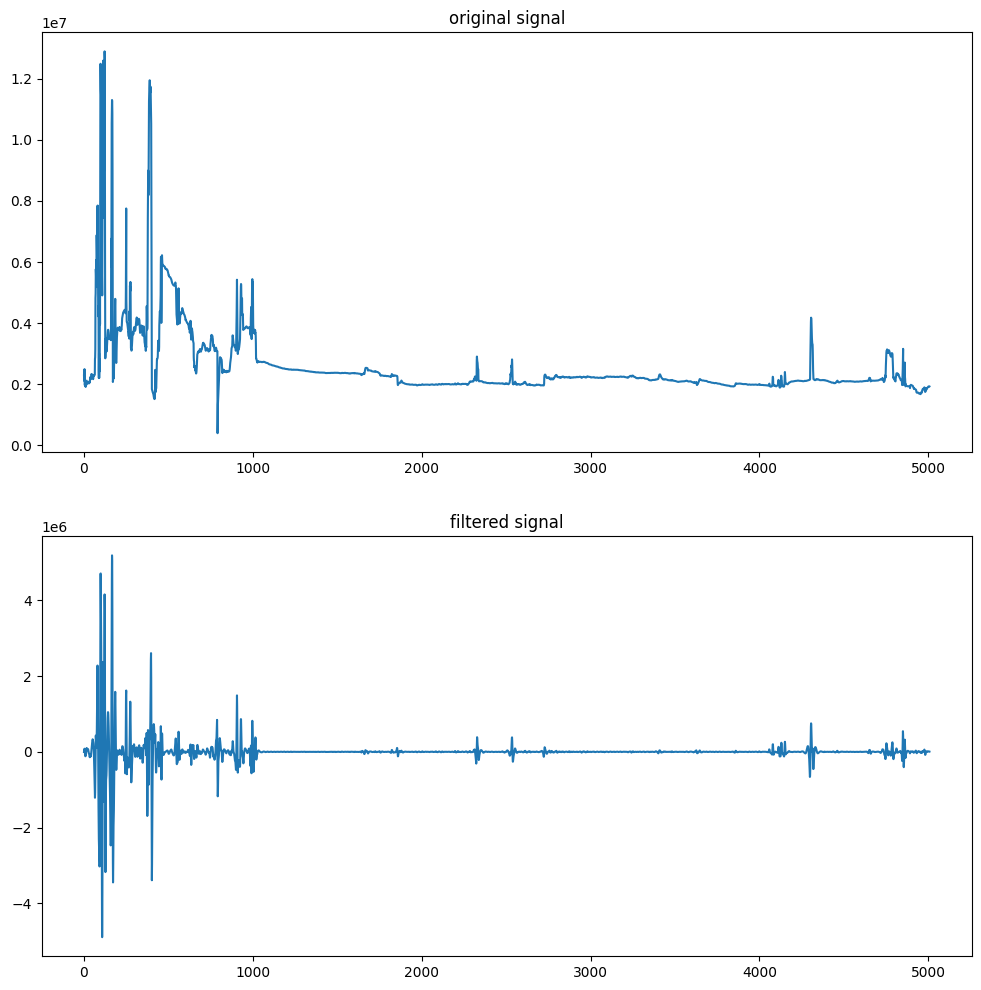

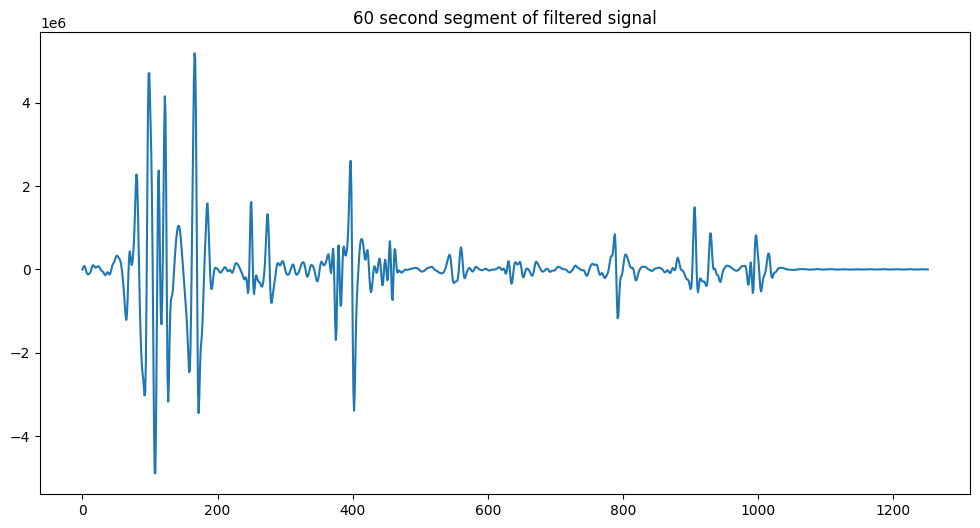

In [24]:
filtered = hp.filter_signal(signal, [0.7, 3.5], sample_rate=sample_rate,
                            order=3, filtertype='bandpass')

#let's plot first 240 seconds and work with that!
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(signal[0:int(240 * sample_rate)])
plt.title('original signal')
plt.subplot(212)
plt.plot(filtered[0:int(240 * sample_rate)])
plt.title('filtered signal')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered[0:int(sample_rate * 60)])
plt.title('60 second segment of filtered signal')
plt.show()


In [25]:
#let's resample to ~100Hz as well
#10Hz is low for the adaptive threshold analysis HeartPy uses
from scipy.signal import resample

resampled = resample(filtered, len(filtered) * 5)

#don't forget to compute the new sampling rate
new_sample_rate = sample_rate * 5

In [27]:
#run HeartPy over a few segments, fingers crossed, and plot results of each
for s in [[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]]:
    wd, m = hp.process(resampled[s[0]:s[1]], sample_rate = new_sample_rate,
                       high_precision=True, clean_rr=True)
    hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    hp.plot_poincare(wd, m)
    plt.show()
    for measure in m.keys():
        print('%s: %f' %(measure, m[measure]))


BadSignalWarning: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------


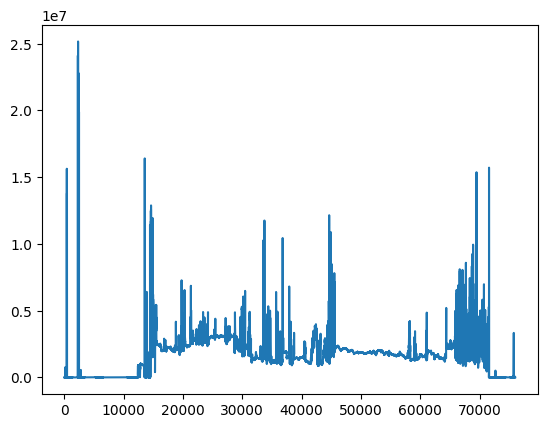

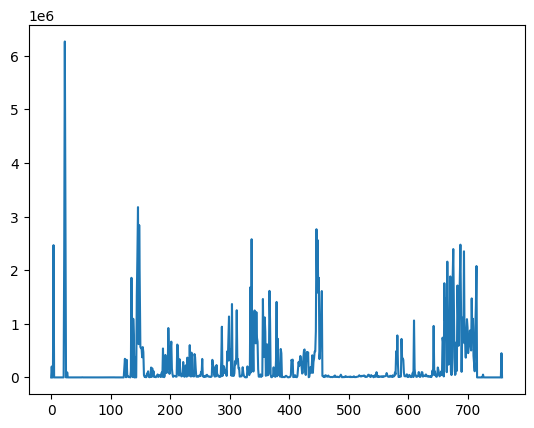

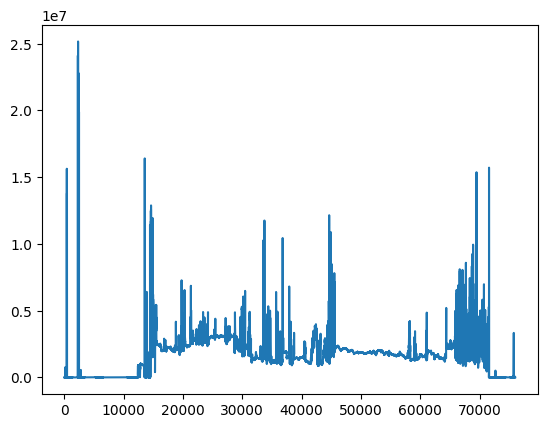

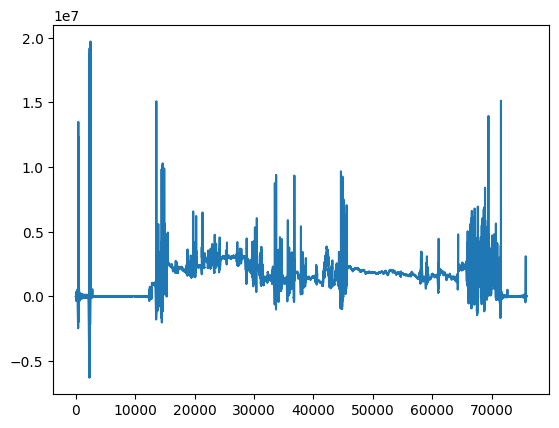

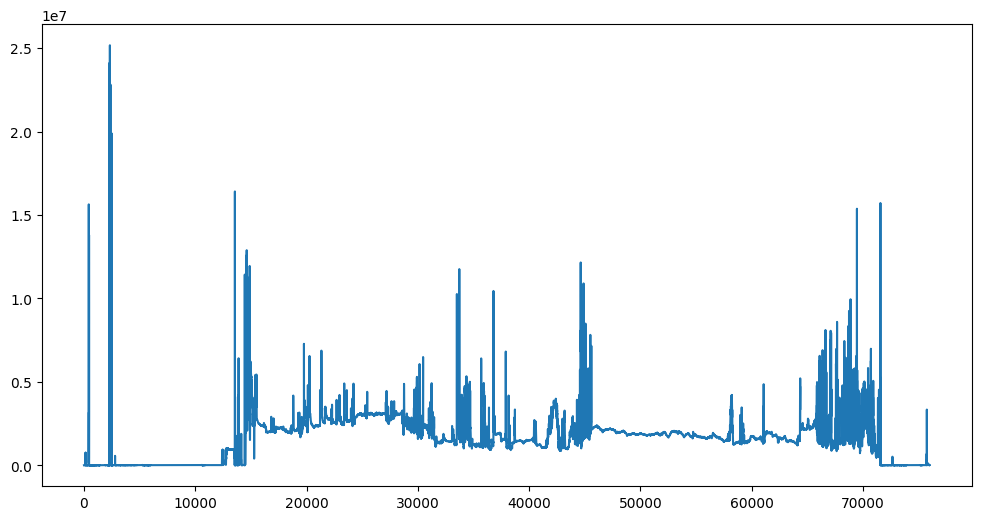

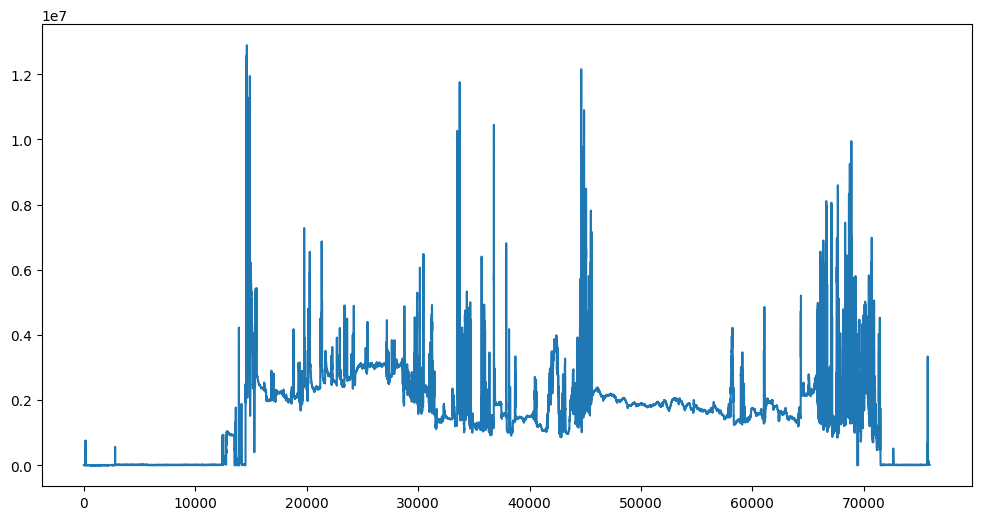

In [34]:
raw = df['ppg'].values

plt.plot(raw)
plt.show()

import sys
from scipy.signal import resample

windowsize = 100
std = []

for i in range(len(raw) // windowsize):
    start = i * windowsize
    end = (i + 1) * windowsize
    sliced = raw[start:end]
    try:
        std.append(np.std(sliced))
    except:
        print(i)

plt.plot(std)
plt.show()

plt.plot(raw)
plt.show()

plt.plot(raw[0:(len(raw) // windowsize) * windowsize] - resample(std, len(std)*windowsize))
plt.show()

(len(raw) // windowsize) * windowsize


mx = np.max(raw)
mn = np.min(raw)
global_range = mx - mn

windowsize = 100
filtered = []

for i in range(len(raw) // windowsize):
    start = i * windowsize
    end = (i + 1) * windowsize
    sliced = raw[start:end]
    rng = np.max(sliced) - np.min(sliced)

    if ((rng >= (0.5 * global_range))
        or
        (np.max(sliced) >= 0.9 * mx)
        or
        (np.min(sliced) <= mn + (0.1 * mn))):

        for x in sliced:
            filtered.append(0)
    else:
        for x in sliced:
            filtered.append(x)

plt.figure(figsize=(12,6))
plt.plot(raw)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered)
plt.show()

In [15]:
from scipy.signal import resample

resampled = resample(filtered, len(filtered) * 5)

#don't forget to compute the new sampling rate
new_sample_rate = sample_rate * 5

#run HeartPy over a few segments, fingers crossed, and plot results of each
for s in [[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]]:
    wd, m = hp.process(resampled[s[0]:s[1]], sample_rate = new_sample_rate,
                       high_precision=True, clean_rr=True)
    hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    hp.plot_poincare(wd, m)
    plt.show()
    for measure in m.keys():
        print('%s: %f' %(measure, m[measure]))

BadSignalWarning: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------
